In [2]:
import sys; sys.path.append('..')
import random, math
import pyzx as zx
from pyzx.linalg import *
from fractions import Fraction
%config InlineBackend.figure_format = 'svg'

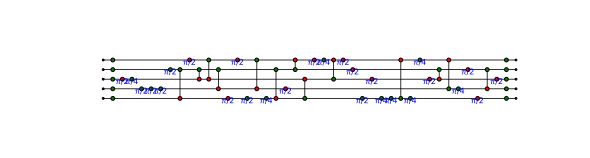

In [26]:
qubit_amount = 5
depth = 40
random.seed(1339)
circ = zx.cliffordT(qubit_amount, depth,p_t=0.2)
zx.draw(circ)#,h_edge_draw='box')

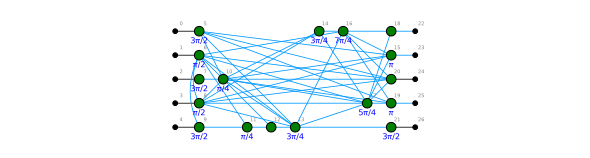

In [31]:
#zx.greedy_cut_extract(g, g.qubit_count())
g = circ.copy()
zx.clifford_simp(g,quiet=True)
g.normalise()
gg = g
g = gg.copy()
zx.draw(g,labels=True)

In [28]:
t = zx.tensor.tensorfy(circ)
t2 = zx.tensor.tensorfy(g)
zx.tensor.compare_tensors(t,t2)

MemoryError: 

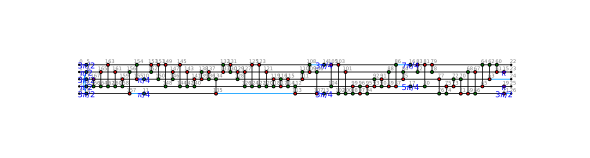

In [32]:
#zx.extract.greedy_cut_extract(g)
zx.extract.circuit_extract(g)
zx.draw(g,labels=True)

In [33]:
t3 = zx.tensor.tensorfy(g)
zx.tensor.compare_tensors(t,t3)

True

In [32]:
from pyzx.extract import split, cut_rank, cut_edges, unspider
qubits = g.qubit_count()
g.normalise()
max_r = g.depth() - 1
i_vs = sorted([v for v in g.vertices() if 1 < g.row(v) < max_r],key=g.row)
row = [i_vs.pop(0)]
left,right = split(g, below=g.row(row[0]), above=g.row(row[-1]))
rank = cut_rank(g, left, right)
r = max(g.row(v) for v in left)+2
r

3

In [28]:
def greedy_cut_extract(g):
    """Given a graph that has been put into semi-normal form by
    :func:`simplify.clifford_simp` it cuts the graph at $\pi/4$ nodes
    so that it is easier to get a circuit back out again.
    It tries to get as many $\pi/4$ gates on the same row as possible
    as to reduce the T-depth of the circuit."""
    qubits = g.qubit_count()
    g.normalise()
    max_r = g.depth() - 1
    i_vs = sorted([v for v in g.vertices() if 1 < g.row(v) < max_r],key=g.row)
    while len(i_vs) > 0:
        row = [i_vs.pop(0)]
        while True:
            left,right = split(g, below=g.row(row[0]), above=g.row(row[-1]))
            #left = before(g, row)
            #right = after(g, row)
            rank = cut_rank(g, left, right)

            if rank + len(row) == qubits:
                if len(i_vs) > 0:
                    row.append(i_vs.pop(0))
                else: break
            elif rank + len(row) > qubits:
                if len(row) == 1:
                    print("FAILED at row", row, "with rank", rank, ">=", qubits, "qubits")
                    return False
                i_vs.insert(0, row.pop())
                left,right = split(g, below=g.row(row[0]), above=g.row(row[-1]))
                if len(left) + len(right) + len(row) != len(g.vertices()):
                    print("row partition does not cover entire graph!")
                rank = cut_rank(g, left, right)
                break
            else:
                print("got len(row) + rank < qubits. For circuits, this should not happen!")
                return False
        
        r = max(g.row(v) for v in left)+1.5
        available = set(range(qubits))
        for v in row:
            q = g.qubit(v)
            if q in available:
                available.remove(q)
            else:
                q = available.pop()
                g.set_qubit(v, q)
            g.set_row(v,r)
            unspider(g, v)

        cut_edges(g, left, right, available)
        
        # for i,v in enumerate(row):
        #     g.set_qubit(v,rank+i)
        #     g.set_row(v,r)
        #     unspider(g, v)
        #if iterate: yield g
    g.pack_circuit_rows()
    return True

In [5]:
qubits = 7
i = 0
while True:
    i += 1
    if i%10 == 0:
        print(i)
    seed = random.randint(0,20000)
    random.seed(seed)
    circ = zx.generate.cliffordT(qubits, 1000, p_t=0.05)
    g = circ.copy()
    zx.clifford_simp(g, quiet=True)
    zx.extract.circuit_extract(g)

    

10
20


ValueError: Adjency matrix rank does not match amount of qubits

In [6]:
seed

19380

In [2]:
qubits = 7
seed = 19380
random.seed(seed)
circ = zx.generate.cliffordT(qubits, 1000, p_t=0.05)
g = circ.copy()
zx.clifford_simp(g, quiet=True)
zx.extract.normalise(g)
#zx.extract.circuit_extract(g)
zx.draw(g,figsize=(12,5),rows=(25,60))
g.depth()

54

In [3]:
graphs = zx.extract.greedy_cut_extract(g,qubits,iterate=True)
c=11

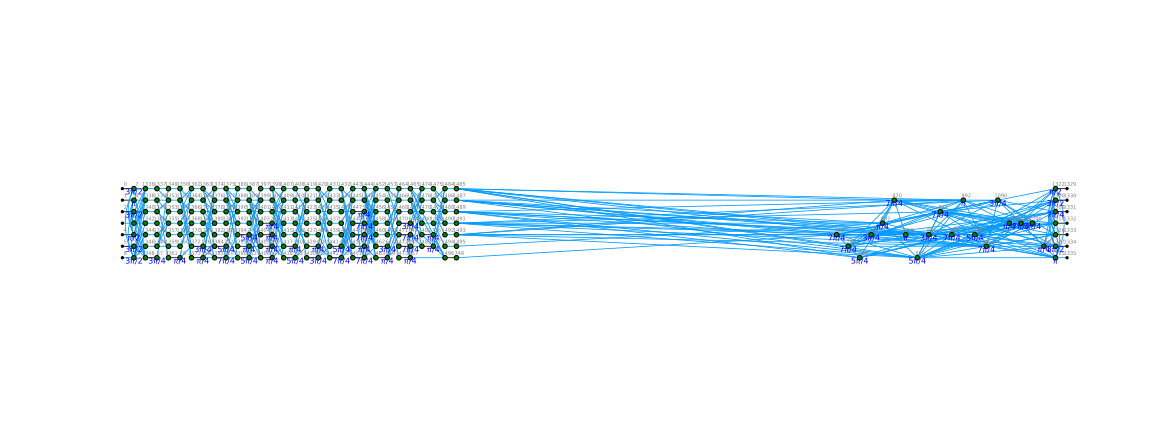

In [6]:
#for i in range(c): next(graphs)
zx.draw(next(graphs),figsize=(16,6),labels=True)

In [31]:
i

14

In [4]:
l = list(reversed(range(1,g.depth()-1,2)))
g2 = g.copy()

In [5]:
#i = l.pop(0)
i = 25
zx.extract.clifford_extract(g2,i,i+1)

woop woop


ValueError: Adjency matrix rank does not match amount of qubits

In [13]:
left_row=25
right_row=26
qubits = g.qubit_count()
qleft = [v for v in g.vertices() if g.row(v)==left_row]
qright= [v for v in g.vertices() if g.row(v)==right_row]
qleft.sort(key=g.qubit)
qright.sort(key=g.qubit)
q=6
vert = min((v for v in g.vertices() if g.qubit(v)==q and g.row(v)>right_row), key=g.row)
conn2 = max((n for n in g.neighbours(vert) if g.qubit(n)==q and g.row(n)<=left_row),key=g.row)
e = g.edge(conn2,vert)
t = g.edge_type(e)
[g.row(v) for v in g.neighbours(1496)]

[27, 25, 25, 25, 25, 29]

In [6]:
l = [1,2,3]
l.insert(3,4)
l

[1, 2, 3, 4]

In [22]:
i

25

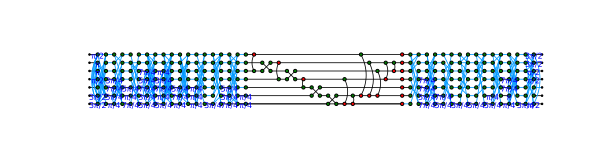

In [105]:
zx.draw(g2)

spider_simp
32. 16. 12. 4. 4. 1. 
finished in 7 iterations
spider_simp

finished in 1 iterations
pivot_simp
9. 5. 2. 
finished in 4 iterations
lcomp_simp
16. 7. 6. 2. 2. 1. 
finished in 7 iterations
pivot_simp
1. 1. 
finished in 3 iterations
id_simp

finished in 1 iterations
spider_simp

finished in 1 iterations


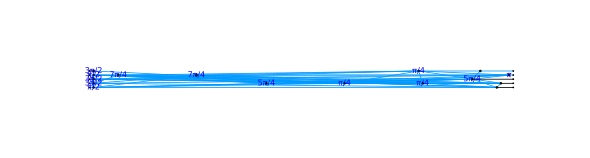

In [5]:
qubits = 5

#random.seed(240)
random.seed(3423)

circ = zx.generate.cliffordT(qubits, 100, p_t=0.1)
#print(zx.t_count(circ))
zx.clifford_simp(circ)
zx.draw(circ)

In [77]:
print(zx.t_count(circ))
print(circ.num_vertices() - qubits * 4)

15
16


In [4]:
from pyzx.extract import *

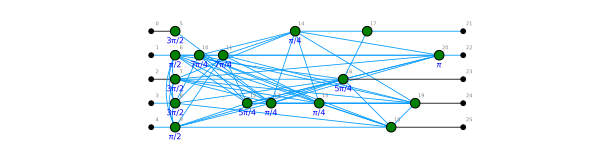

In [6]:
g = circ.copy()
zx.pack_circuit_rows(g)
zx.draw(g, labels=True)

In [7]:
zx.extract.circuit_extract(g)

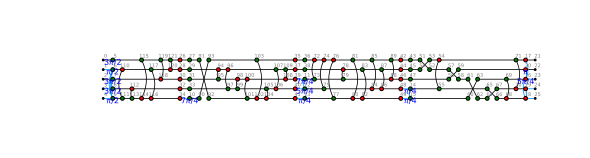

In [8]:
zx.draw(g,labels=True)

In [10]:
for i in range(1, 20, 2):
    print(i)

1
3
5
7
9
11
13
15
17
19


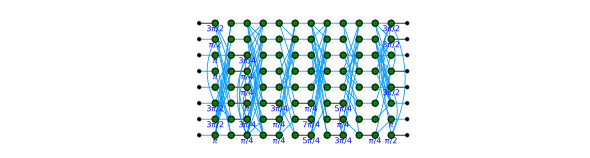

In [4]:
zx.extract.greedy_cut_extract(g, qubits)
zx.pack_circuit_rows(g)
zx.draw(g)

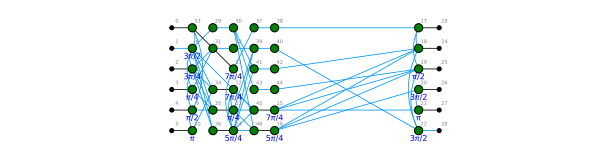

In [23]:
#zx.drawing.pack_circuit_rows(g)
#zx.drawing.
#g.set_qubit(6,0.8)
g.set_row(33,1)
g.set_qubit(33,0)
zx.draw(g, labels=True)

In [22]:
print(g.neighbours(33))
print(g.neighbours(6))

dict_keys([0, 9, 11, 6])
dict_keys([1, 34, 35, 36, 33, 7, 8, 45, 29])


In [57]:
def gadgetize(g, qubits):
    newv = g.vindex
    for v in list(g.vertices()):
        va = g.get_angle(v)
        vt = g.get_type(v)
        vq = g.get_vdata(v,'q')
        vr = g.get_vdata(v,'r')
        if va.denominator > 2:
            g.set_angle(v, 0)
            
            g.add_vertex()
            g.set_type(newv, 2)
            g.set_vdata(newv, 'q', qubits)
            g.set_vdata(newv, 'r', vr)
            newv+=1
            
            g.add_vertex()
            g.set_type(newv, vt)
            g.set_angle(newv, va)
            g.set_vdata(newv, 'q', qubits+1)
            g.set_vdata(newv, 'r', vr)
            newv += 1
            
            g.add_edges([(v,newv-2),(newv-2,newv-1)])

In [13]:
zx.spider_simp(circ)
zx.drawing.pack_circuit_ranks(circ)
gadgetize(circ)

spider_simp

finished in 1 iterations


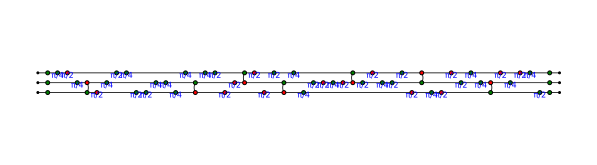

In [74]:
zx.draw(circ)

In [3]:
random.seed(1337)
circ = zx.examples.cliffordT(3, 1000, p_t=0.02)
print('t-count:', zx.t_count(circ))
zx.clifford_simp(circ)
zx.drawing.pack_circuit_ranks(circ)
print('t-count:', zx.t_count(circ))

t-count: 11
spider_simp
260. 185. 113. 64. 37. 13. 7. 2. 1. 
finished in 10 iterations
pivot_simp
75. 36. 11. 2. 
finished in 5 iterations
lcomp_simp
168. 60. 46. 33. 25. 15. 10. 8. 4. 4. 3. 3. 3. 2. 3. 2. 2. 2. 1. 2. 2. 1. 
finished in 23 iterations
pivot_simp
1. 
finished in 2 iterations
t-count: 7


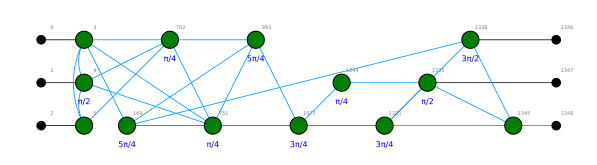

In [4]:
zx.draw(circ, labels=True)

In [12]:
# WORKS
#random.seed(1337)
#circ = zx.examples.cliffordT(4, 400, p_t=0.1)

# WORKS
random.seed(140)
circ = zx.examples.cliffordT(4, 40, p_t=0.5)
print('t-count:', zx.t_count(circ))
zx.clifford_simp(circ)
zx.drawing.pack_circuit_ranks(circ)
print('t-count:', zx.t_count(circ))

t-count: 15
spider_simp
11. 7. 5. 1. 1. 1. 
finished in 7 iterations
pivot_simp
1. 1. 
finished in 3 iterations
lcomp_simp
9. 1. 1. 1. 
finished in 5 iterations
pivot_simp

finished in 1 iterations
t-count: 5


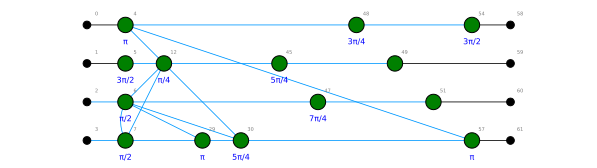

In [13]:
zx.draw(circ, labels=True)

terminated normally


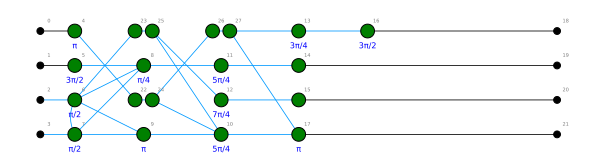

In [15]:
g = circ.copy()
zx.cut_extract(g,4)
zx.draw(g, labels=True)

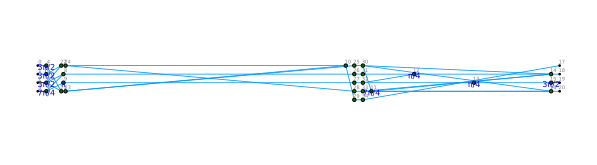

In [3]:
#g = circ.copy()
#zx.pack_circuit_ranks(g)
zx.draw(g,labels=True)

In [10]:
zx.extract.after(g,[8,21,22,23])
zx.extract.bi_adj(g,[8,21,22,23],[10, 25, 26, 27]).rank()

4

In [11]:
zx.clifford_simp(g)

spider_simp

finished in 1 iterations
pivot_simp
4. 2. 2. 1. 
finished in 5 iterations
lcomp_simp
1. 
finished in 2 iterations
pivot_simp

finished in 1 iterations


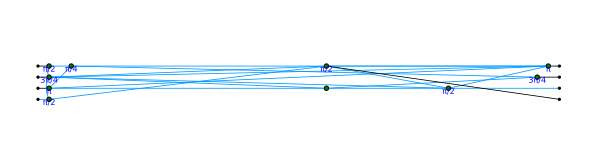

In [12]:
zx.draw(g)

In [5]:
qubits = 4

random.seed(240)

for i in range(126):
    circ = zx.generate.cliffordT(qubits, 40, p_t=0.1)
circ = zx.generate.cliffordT(qubits, 40, p_t=0.1)
zx.clifford_simp(circ)
g = circ.copy()
#zx.cut_extract(g,qubits)

spider_simp
11. 7. 4. 3. 1. 
finished in 6 iterations
pivot_simp
4. 3. 
finished in 3 iterations
lcomp_simp
7. 2. 1. 
finished in 4 iterations
pivot_simp
2. 
finished in 2 iterations
id_simp

finished in 1 iterations


[8, 9, 10, 11, 14, 16]
2
[10, 11, 12, 13, 14, 16]
1


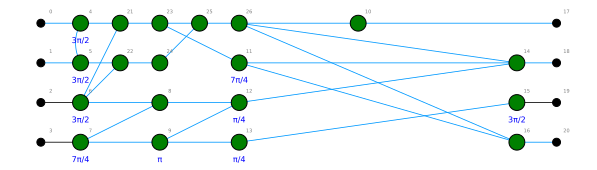

In [20]:
g = circ.copy()
zx.pack_circuit_ranks(g)
print(zx.extract.after(g, [4,5,6,7]))
print(zx.extract.bi_adj(g, [4,5,6,7], [10, 11, 14, 16]).rank())
zx.extract.cut_edges(g, [4,5,6,7], [10, 11, 14, 16])
g.set_vdata(8, 'r', 3)
g.set_vdata(8, 'q', 2)
g.set_vdata(9, 'r', 3)
g.set_vdata(9, 'q', 3)
print(zx.extract.after(g,set([8,9,23,24])))
print(zx.extract.bi_adj(g,[8,9,23,24],[10,14,16]).rank())
zx.extract.cut_edges(g,[8,9,23,24],[10,14,16])
g.set_vdata(11, 'r', 5)
g.set_vdata(11, 'q', 1)
g.set_vdata(12, 'r', 5)
g.set_vdata(12, 'q', 2)
g.set_vdata(13, 'r', 5)
g.set_vdata(13, 'q', 3)
zx.draw(g,labels=True)

In [31]:
s = set([1,2,3])
s.add(4)
s

{1, 2, 3, 4}

In [5]:
g.get_vdata(0,'i')

0

In [33]:
row = [1,4,3,2]
list.sort(row)
row

[1, 2, 3, 4]

In [10]:
range(3,6)[1]

4